In [118]:
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from eqcorrscan.utils.mag_calc import dist_calc
from obspy import read_events, UTCDateTime, Catalog, read_inventory

# Location uncertainties in time

In [2]:
cat_Rot = read_events('/home/chet/GrowClust/Mercury/Final_catalogs_3-19-19/Rotokawa_Catalog_Final_5-17-19.xml')

In [37]:
cat_Rot_just_GC = Catalog(events=[ev for ev in cat_Rot if ev.preferred_origin().method_id])

Make a series of arrays of basic uncertainty information including: azimuthal gap, location uncertainties with time

In [69]:
time_vect = [ev.origins[-1].time.datetime for ev in cat_Rot_just_GC]

In [83]:
az_gaps = [ev.origins[0].quality.azimuthal_gap for ev in cat_Rot_just_GC]
mean_gap = pd.Series(az_gaps).rolling(window=100).mean().iloc[100 - 1:].values

In [96]:
max_horiz_uncerts = []
min_horiz_uncerts = []
for ev in cat_Rot_just_GC:
    nlloc_o = [o for o in ev.origins if o.quality and o.creation_info][-1]
    max_horiz_uncerts.append(nlloc_o.origin_uncertainty.max_horizontal_uncertainty)
    min_horiz_uncerts.append(nlloc_o.origin_uncertainty.min_horizontal_uncertainty)
mean_max = pd.Series(max_horiz_uncerts).rolling(window=100).mean().iloc[100 - 1:].values
mean_min = pd.Series(min_horiz_uncerts).rolling(window=100).mean().iloc[100 - 1:].values

<IPython.core.display.Javascript object>


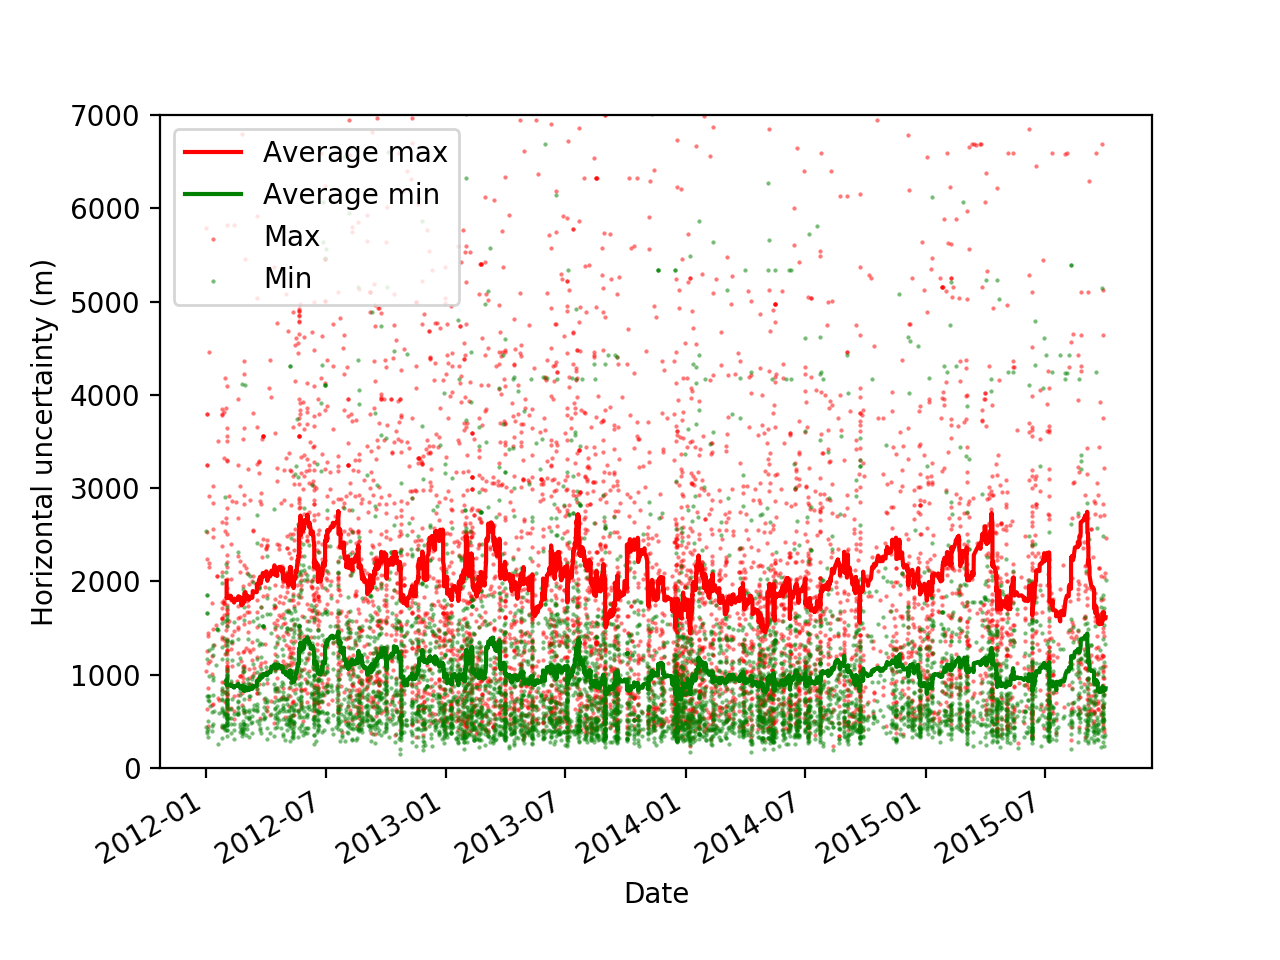

Text(0, 0.5, 'Horizontal uncertainty (m)')

In [98]:
fig, ax = plt.subplots()
ax.scatter(time_vect, max_horiz_uncerts, color='red', alpha=0.5, s=0.3, label='Max')
ax.scatter(time_vect, min_horiz_uncerts, color='green', alpha=0.5, s=0.3, label='Min')
ax.plot(time_vect[100 - 1:], mean_max, color='red', label='Average max')
ax.plot(time_vect[100 - 1:], mean_min, color='green', label='Average min')
plt.legend()
fig.autofmt_xdate()
ax.set_ylim([0, 7000])
ax.set_xlabel('Date')
ax.set_ylabel('Horizontal uncertainty (m)')

<IPython.core.display.Javascript object>


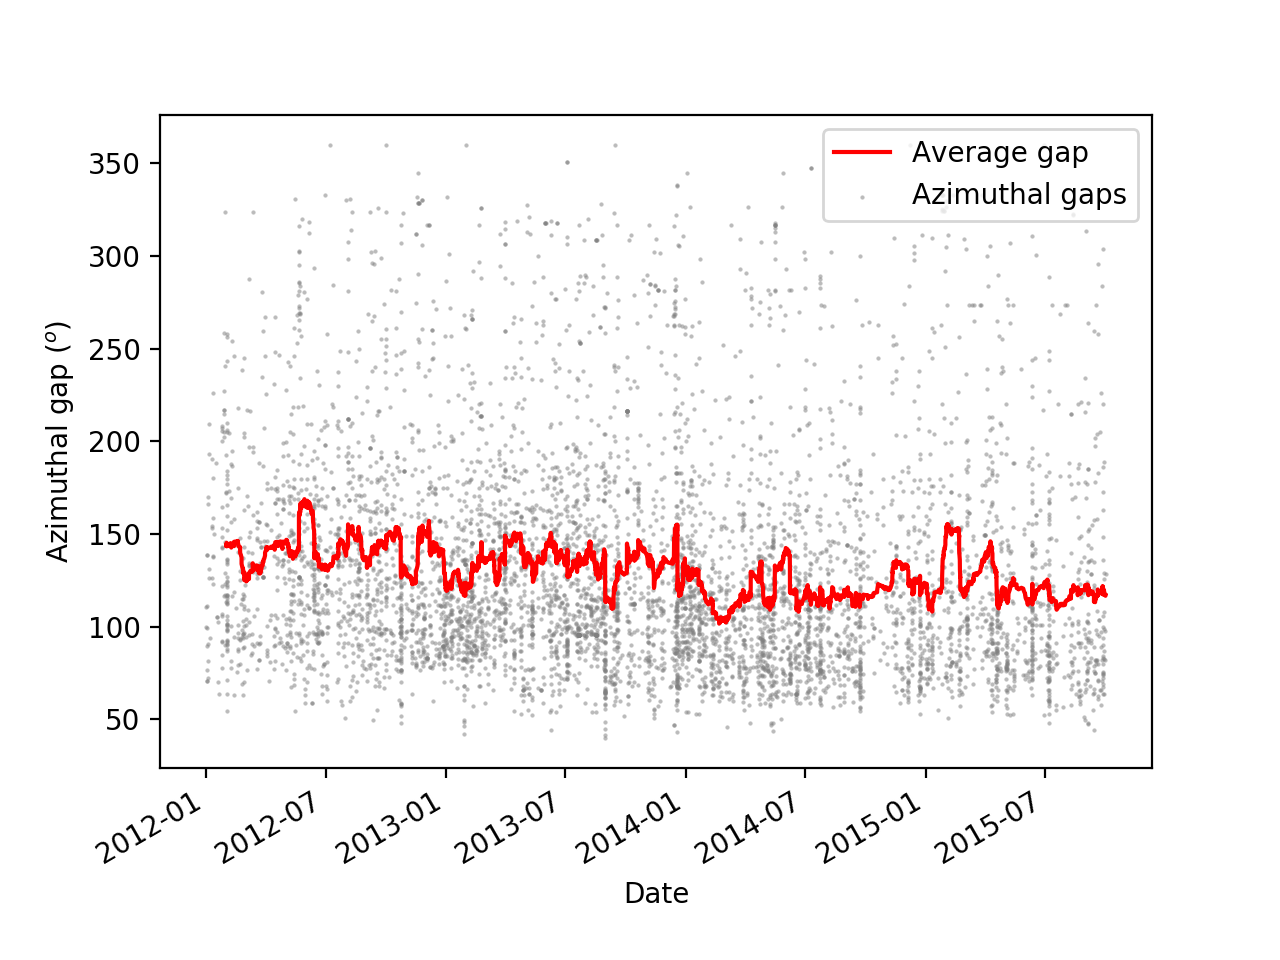

Text(0, 0.5, 'Azimuthal gap ($^o$)')

In [87]:
fig, ax = plt.subplots()
ax.scatter(time_vect, az_gaps, color='grey', alpha=0.5, s=0.3, label='Azimuthal gaps')
ax.plot(time_vect[100 - 1:], mean_gap, color='red', label='Average gap')
plt.legend()
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Azimuthal gap ($^o$)')

## S-pick distances

In [119]:
# Read in the inventory
inv = read_inventory('/home/chet/data/mrp_data/stations/Mercury_inventory_final_3-13-19.xml')

In [125]:
S_dists = []
for ev in cat_Rot:
    for pk in ev.picks:
        if pk.phase_hint == 'S':
            sta = inv.select(station=pk.waveform_id.station_code)
            S_dists.append(dist_calc((sta[0][0].latitude, sta[0][0].longitude, 0.3),
                                     (ev.preferred_origin().latitude,
                                      ev.preferred_origin().longitude,
                                      ev.preferred_origin().depth / 1000.)))
print('Average S-phase raypath length: {} km'.format(np.mean(S_dists)))

Average S-phase raypath length: 5.376190669374664 km


<IPython.core.display.Javascript object>


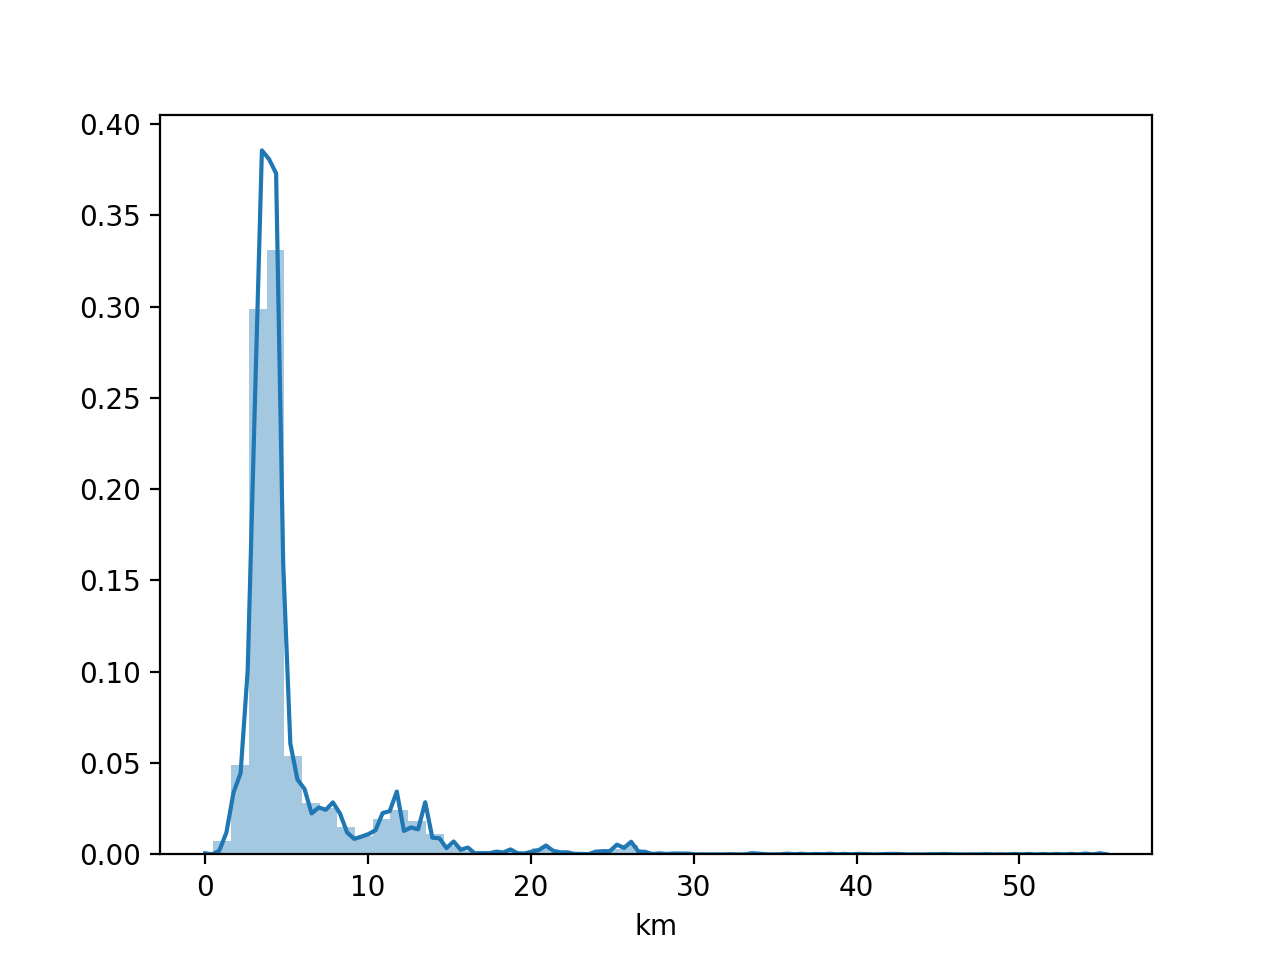

Text(0.5, 0, 'km')

In [126]:
ax = sns.distplot(S_dists, label='S-phase raypath distances')
ax.set_xlabel('km')

# Family inter-event distances

In [110]:
# Make list of templates and a dictionary of events for each family
temps = list(set([ev.resource_id.id.split('/')[-1].split('_')[0] for ev in cat_Rot_just_GC]))
fam_dict = {temp: [ev for ev in cat_Rot_just_GC
                   if ev.resource_id.id.split('/')[-1].split('_')[0] == temp]
            for temp in temps}

In [111]:
# List of self_detection names
with open('/media/chet/hdd/seismic/NZ/detections/self_detection_names.csv', 'r') as f: 
    selfs = [] 
    for ln in f: 
        line = ln.rstrip('\n') 
        selfs.append(line)

In [112]:
# Loop families, find template, save average interevent distance
avg_dists = {}
for temp, events in fam_dict.items():
    master = [e for e in events if e.resource_id.id.split('/')[-1] in selfs]
    if len(master) > 0:
        avg_dists[temp] = np.mean([dist_calc((ev.preferred_origin().latitude,
                                              ev.preferred_origin().longitude,
                                              ev.preferred_origin().depth / 1000.),
                                             (master[0].preferred_origin().latitude,
                                              master[0].preferred_origin().longitude,
                                              master[0].preferred_origin().depth / 1000.))
                                   for ev in events])

In [113]:
dists = [d for temp, d in avg_dists.items()]
print('Average mean template-detection distance (km): {}'.format(np.mean(dists)))

Average mean template-detection distance (km): 0.23385356502821936


<IPython.core.display.Javascript object>


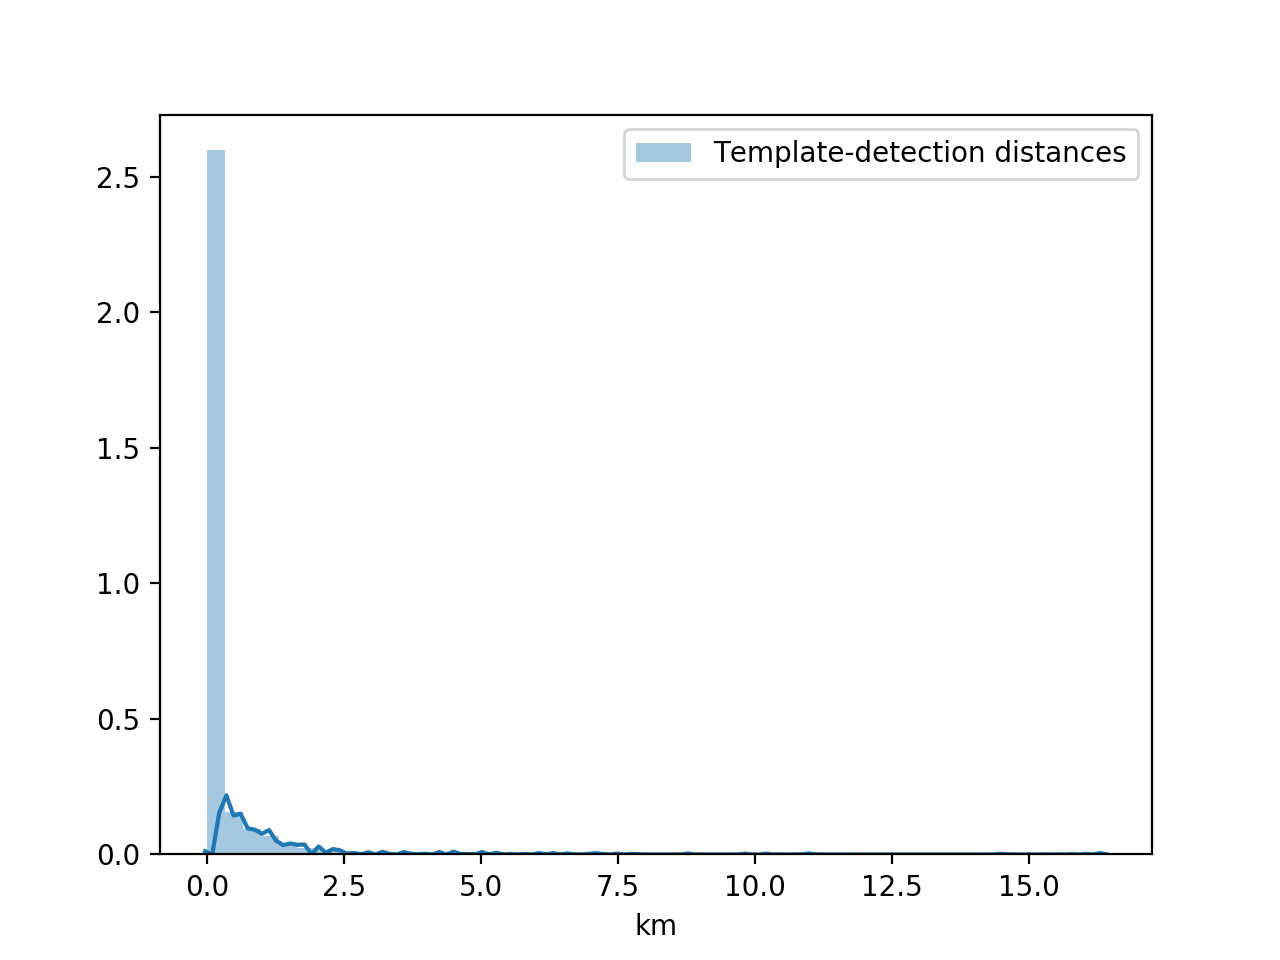

Text(0.5, 0, 'km')

In [116]:
ax = sns.distplot(dists, label='Template-detection distances')
plt.legend()
ax.set_xlabel('km')